# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils.vis_utils import plot_model
import pydot

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          1152        input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 128)          16512       dense_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 64)           8256        dense_4[0][0]                    
____________________________________________________________________________________________

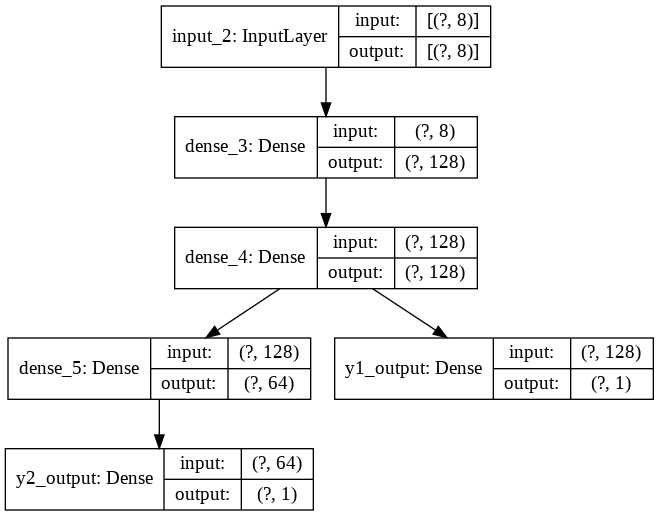

In [5]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

# from tensorflow.keras.layers import Layer
# model. layers = [
#     layer for layer in model._layers if isinstance(layer, Layer)
# ]
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
# plot_model(model)

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [6]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [7]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 1ms/sample - loss: 237.8939 - y1_output_loss: 110.4797 - y2_output_loss: 125.1713 - y1_output_root_mean_squared_error: 10.5606 - y2_output_root_mean_squared_error: 11.2413 - val_loss: 29.5333 - val_y1_output_loss: 11.7038 - val_y2_output_loss: 17.1776 - val_y1_output_root_mean_squared_error: 3.4557 - val_y2_output_root_mean_squared_error: 4.1942
Epoch 2/500
614/614 [==============================] - 0s 156us/sample - loss: 34.8283 - y1_output_loss: 12.9110 - y2_output_loss: 21.6488 - y1_output_root_mean_squared_error: 3.6090 - y2_output_root_mean_squared_error: 4.6694 - val_loss: 21.8313 - val_y1_output_loss: 9.5566 - val_y2_output_loss: 12.0795 - val_y1_output_root_mean_squared_error: 3.1040 - val_y2_output_root_mean_squared_error: 3.4923
Epoch 3/500
614/614 [==============================] - 0s 153us/sample - loss: 26.5181 - y1_output_loss: 10.4423 - y2_output_loss: 16.0308 - y1_ou

614/614 [==============================] - 0s 143us/sample - loss: 15.1154 - y1_output_loss: 5.7164 - y2_output_loss: 9.2597 - y1_output_root_mean_squared_error: 2.4020 - y2_output_root_mean_squared_error: 3.0571 - val_loss: 12.0140 - val_y1_output_loss: 4.7352 - val_y2_output_loss: 8.0111 - val_y1_output_root_mean_squared_error: 2.0311 - val_y2_output_root_mean_squared_error: 2.8087
Epoch 22/500
614/614 [==============================] - 0s 144us/sample - loss: 13.8585 - y1_output_loss: 5.4424 - y2_output_loss: 8.6736 - y1_output_root_mean_squared_error: 2.3129 - y2_output_root_mean_squared_error: 2.9171 - val_loss: 40.4183 - val_y1_output_loss: 10.5450 - val_y2_output_loss: 28.9557 - val_y1_output_root_mean_squared_error: 3.2816 - val_y2_output_root_mean_squared_error: 5.4452
Epoch 23/500
614/614 [==============================] - 0s 140us/sample - loss: 15.1333 - y1_output_loss: 5.6038 - y2_output_loss: 9.4726 - y1_output_root_mean_squared_error: 2.3741 - y2_output_root_mean_squared

614/614 [==============================] - 0s 136us/sample - loss: 8.2039 - y1_output_loss: 2.6610 - y2_output_loss: 5.5941 - y1_output_root_mean_squared_error: 1.6126 - y2_output_root_mean_squared_error: 2.3672 - val_loss: 14.5244 - val_y1_output_loss: 5.0781 - val_y2_output_loss: 9.0763 - val_y1_output_root_mean_squared_error: 2.2720 - val_y2_output_root_mean_squared_error: 3.0598
Epoch 42/500
614/614 [==============================] - 0s 133us/sample - loss: 8.1689 - y1_output_loss: 2.5553 - y2_output_loss: 5.5829 - y1_output_root_mean_squared_error: 1.5946 - y2_output_root_mean_squared_error: 2.3719 - val_loss: 15.9636 - val_y1_output_loss: 5.5488 - val_y2_output_loss: 10.0351 - val_y1_output_root_mean_squared_error: 2.3746 - val_y2_output_root_mean_squared_error: 3.2132
Epoch 43/500
614/614 [==============================] - 0s 135us/sample - loss: 7.2024 - y1_output_loss: 2.4516 - y2_output_loss: 4.8301 - y1_output_root_mean_squared_error: 1.5557 - y2_output_root_mean_squared_err

Epoch 62/500
614/614 [==============================] - 0s 154us/sample - loss: 4.6532 - y1_output_loss: 1.2693 - y2_output_loss: 3.3481 - y1_output_root_mean_squared_error: 1.1313 - y2_output_root_mean_squared_error: 1.8367 - val_loss: 5.9334 - val_y1_output_loss: 1.4094 - val_y2_output_loss: 4.5211 - val_y1_output_root_mean_squared_error: 1.1469 - val_y2_output_root_mean_squared_error: 2.1490
Epoch 63/500
614/614 [==============================] - 0s 138us/sample - loss: 7.2349 - y1_output_loss: 1.9555 - y2_output_loss: 5.2258 - y1_output_root_mean_squared_error: 1.4026 - y2_output_root_mean_squared_error: 2.2951 - val_loss: 4.8091 - val_y1_output_loss: 1.3377 - val_y2_output_loss: 3.5478 - val_y1_output_root_mean_squared_error: 1.1087 - val_y2_output_root_mean_squared_error: 1.8921
Epoch 64/500
614/614 [==============================] - 0s 145us/sample - loss: 5.6061 - y1_output_loss: 1.6486 - y2_output_loss: 4.0343 - y1_output_root_mean_squared_error: 1.2770 - y2_output_root_mean_s

Epoch 83/500
614/614 [==============================] - 0s 141us/sample - loss: 3.9828 - y1_output_loss: 0.9225 - y2_output_loss: 3.1024 - y1_output_root_mean_squared_error: 0.9539 - y2_output_root_mean_squared_error: 1.7530 - val_loss: 17.1383 - val_y1_output_loss: 4.9784 - val_y2_output_loss: 11.7589 - val_y1_output_root_mean_squared_error: 2.2700 - val_y2_output_root_mean_squared_error: 3.4620
Epoch 84/500
614/614 [==============================] - 0s 139us/sample - loss: 2.9479 - y1_output_loss: 0.7291 - y2_output_loss: 2.1913 - y1_output_root_mean_squared_error: 0.8579 - y2_output_root_mean_squared_error: 1.4873 - val_loss: 3.2639 - val_y1_output_loss: 0.8748 - val_y2_output_loss: 2.3303 - val_y1_output_root_mean_squared_error: 0.9361 - val_y2_output_root_mean_squared_error: 1.5452
Epoch 85/500
614/614 [==============================] - 0s 134us/sample - loss: 3.7536 - y1_output_loss: 0.9218 - y2_output_loss: 2.8249 - y1_output_root_mean_squared_error: 0.9593 - y2_output_root_mean

Epoch 104/500
614/614 [==============================] - 0s 131us/sample - loss: 2.7690 - y1_output_loss: 0.6519 - y2_output_loss: 2.1002 - y1_output_root_mean_squared_error: 0.8088 - y2_output_root_mean_squared_error: 1.4543 - val_loss: 3.1796 - val_y1_output_loss: 0.7536 - val_y2_output_loss: 2.4152 - val_y1_output_root_mean_squared_error: 0.8525 - val_y2_output_root_mean_squared_error: 1.5661
Epoch 105/500
614/614 [==============================] - 0s 130us/sample - loss: 10.4851 - y1_output_loss: 3.2599 - y2_output_loss: 7.2126 - y1_output_root_mean_squared_error: 1.8092 - y2_output_root_mean_squared_error: 2.6855 - val_loss: 11.6979 - val_y1_output_loss: 1.6004 - val_y2_output_loss: 10.1084 - val_y1_output_root_mean_squared_error: 1.2361 - val_y2_output_root_mean_squared_error: 3.1890
Epoch 106/500
614/614 [==============================] - 0s 130us/sample - loss: 4.1323 - y1_output_loss: 1.1011 - y2_output_loss: 3.0177 - y1_output_root_mean_squared_error: 1.0518 - y2_output_root_

614/614 [==============================] - 0s 133us/sample - loss: 2.0886 - y1_output_loss: 0.4115 - y2_output_loss: 1.6651 - y1_output_root_mean_squared_error: 0.6419 - y2_output_root_mean_squared_error: 1.2948 - val_loss: 3.2585 - val_y1_output_loss: 0.6439 - val_y2_output_loss: 2.5607 - val_y1_output_root_mean_squared_error: 0.7869 - val_y2_output_root_mean_squared_error: 1.6246
Epoch 125/500
614/614 [==============================] - 0s 137us/sample - loss: 1.9644 - y1_output_loss: 0.4289 - y2_output_loss: 1.5328 - y1_output_root_mean_squared_error: 0.6545 - y2_output_root_mean_squared_error: 1.2393 - val_loss: 4.8605 - val_y1_output_loss: 0.4724 - val_y2_output_loss: 4.3043 - val_y1_output_root_mean_squared_error: 0.6939 - val_y2_output_root_mean_squared_error: 2.0926
Epoch 126/500
614/614 [==============================] - 0s 142us/sample - loss: 1.7312 - y1_output_loss: 0.3431 - y2_output_loss: 1.3812 - y1_output_root_mean_squared_error: 0.5861 - y2_output_root_mean_squared_erro

Epoch 145/500
614/614 [==============================] - 0s 144us/sample - loss: 3.2608 - y1_output_loss: 0.8598 - y2_output_loss: 2.3837 - y1_output_root_mean_squared_error: 0.9251 - y2_output_root_mean_squared_error: 1.5508 - val_loss: 2.1841 - val_y1_output_loss: 0.5921 - val_y2_output_loss: 1.5672 - val_y1_output_root_mean_squared_error: 0.7514 - val_y2_output_root_mean_squared_error: 1.2726
Epoch 146/500
614/614 [==============================] - 0s 136us/sample - loss: 1.5708 - y1_output_loss: 0.3385 - y2_output_loss: 1.2475 - y1_output_root_mean_squared_error: 0.5826 - y2_output_root_mean_squared_error: 1.1097 - val_loss: 5.3645 - val_y1_output_loss: 0.4213 - val_y2_output_loss: 4.8888 - val_y1_output_root_mean_squared_error: 0.6306 - val_y2_output_root_mean_squared_error: 2.2286
Epoch 147/500
614/614 [==============================] - 0s 137us/sample - loss: 2.1102 - y1_output_loss: 0.5051 - y2_output_loss: 1.5923 - y1_output_root_mean_squared_error: 0.7114 - y2_output_root_mea

614/614 [==============================] - 0s 133us/sample - loss: 1.7574 - y1_output_loss: 0.3822 - y2_output_loss: 1.3951 - y1_output_root_mean_squared_error: 0.6205 - y2_output_root_mean_squared_error: 1.1715 - val_loss: 2.7203 - val_y1_output_loss: 0.5582 - val_y2_output_loss: 2.1451 - val_y1_output_root_mean_squared_error: 0.7440 - val_y2_output_root_mean_squared_error: 1.4720
Epoch 166/500
614/614 [==============================] - 0s 147us/sample - loss: 1.7996 - y1_output_loss: 0.3414 - y2_output_loss: 1.4677 - y1_output_root_mean_squared_error: 0.5851 - y2_output_root_mean_squared_error: 1.2072 - val_loss: 6.2614 - val_y1_output_loss: 0.9129 - val_y2_output_loss: 5.2494 - val_y1_output_root_mean_squared_error: 0.9705 - val_y2_output_root_mean_squared_error: 2.3064
Epoch 167/500
614/614 [==============================] - 0s 148us/sample - loss: 2.1389 - y1_output_loss: 0.5209 - y2_output_loss: 1.6852 - y1_output_root_mean_squared_error: 0.7180 - y2_output_root_mean_squared_erro

Epoch 186/500
614/614 [==============================] - 0s 137us/sample - loss: 1.6693 - y1_output_loss: 0.3978 - y2_output_loss: 1.2594 - y1_output_root_mean_squared_error: 0.6327 - y2_output_root_mean_squared_error: 1.1265 - val_loss: 1.4619 - val_y1_output_loss: 0.2415 - val_y2_output_loss: 1.1945 - val_y1_output_root_mean_squared_error: 0.4847 - val_y2_output_root_mean_squared_error: 1.1076
Epoch 187/500
614/614 [==============================] - 0s 140us/sample - loss: 1.5200 - y1_output_loss: 0.3230 - y2_output_loss: 1.2004 - y1_output_root_mean_squared_error: 0.5669 - y2_output_root_mean_squared_error: 1.0948 - val_loss: 7.3658 - val_y1_output_loss: 1.8398 - val_y2_output_loss: 5.3699 - val_y1_output_root_mean_squared_error: 1.3795 - val_y2_output_root_mean_squared_error: 2.3373
Epoch 188/500
614/614 [==============================] - 0s 150us/sample - loss: 2.0322 - y1_output_loss: 0.4689 - y2_output_loss: 1.5583 - y1_output_root_mean_squared_error: 0.6855 - y2_output_root_mea

614/614 [==============================] - 0s 137us/sample - loss: 1.0929 - y1_output_loss: 0.2475 - y2_output_loss: 0.8935 - y1_output_root_mean_squared_error: 0.4706 - y2_output_root_mean_squared_error: 0.9335 - val_loss: 11.4250 - val_y1_output_loss: 3.1023 - val_y2_output_loss: 8.1912 - val_y1_output_root_mean_squared_error: 1.7649 - val_y2_output_root_mean_squared_error: 2.8827
Epoch 207/500
614/614 [==============================] - 0s 144us/sample - loss: 2.5286 - y1_output_loss: 0.8027 - y2_output_loss: 1.7314 - y1_output_root_mean_squared_error: 0.8974 - y2_output_root_mean_squared_error: 1.3127 - val_loss: 1.3839 - val_y1_output_loss: 0.2703 - val_y2_output_loss: 1.1017 - val_y1_output_root_mean_squared_error: 0.5052 - val_y2_output_root_mean_squared_error: 1.0624
Epoch 208/500
614/614 [==============================] - 0s 137us/sample - loss: 1.5754 - y1_output_loss: 0.3438 - y2_output_loss: 1.2306 - y1_output_root_mean_squared_error: 0.5834 - y2_output_root_mean_squared_err

Epoch 227/500
614/614 [==============================] - 0s 140us/sample - loss: 1.4685 - y1_output_loss: 0.3347 - y2_output_loss: 1.1372 - y1_output_root_mean_squared_error: 0.5810 - y2_output_root_mean_squared_error: 1.0634 - val_loss: 1.2543 - val_y1_output_loss: 0.2049 - val_y2_output_loss: 1.0691 - val_y1_output_root_mean_squared_error: 0.4443 - val_y2_output_root_mean_squared_error: 1.0280
Epoch 228/500
614/614 [==============================] - 0s 138us/sample - loss: 1.0023 - y1_output_loss: 0.2158 - y2_output_loss: 0.7996 - y1_output_root_mean_squared_error: 0.4652 - y2_output_root_mean_squared_error: 0.8865 - val_loss: 1.5364 - val_y1_output_loss: 0.2136 - val_y2_output_loss: 1.3275 - val_y1_output_root_mean_squared_error: 0.4466 - val_y2_output_root_mean_squared_error: 1.1563
Epoch 229/500
614/614 [==============================] - 0s 146us/sample - loss: 1.0328 - y1_output_loss: 0.2150 - y2_output_loss: 0.8119 - y1_output_root_mean_squared_error: 0.4644 - y2_output_root_mea

614/614 [==============================] - 0s 138us/sample - loss: 1.0629 - y1_output_loss: 0.2101 - y2_output_loss: 0.8464 - y1_output_root_mean_squared_error: 0.4604 - y2_output_root_mean_squared_error: 0.9225 - val_loss: 1.7784 - val_y1_output_loss: 0.2503 - val_y2_output_loss: 1.5031 - val_y1_output_root_mean_squared_error: 0.4990 - val_y2_output_root_mean_squared_error: 1.2367
Epoch 248/500
614/614 [==============================] - 0s 145us/sample - loss: 0.9834 - y1_output_loss: 0.2286 - y2_output_loss: 0.7494 - y1_output_root_mean_squared_error: 0.4800 - y2_output_root_mean_squared_error: 0.8677 - val_loss: 1.6902 - val_y1_output_loss: 0.1894 - val_y2_output_loss: 1.4767 - val_y1_output_root_mean_squared_error: 0.4319 - val_y2_output_root_mean_squared_error: 1.2262
Epoch 249/500
614/614 [==============================] - 0s 145us/sample - loss: 0.8429 - y1_output_loss: 0.1785 - y2_output_loss: 0.6606 - y1_output_root_mean_squared_error: 0.4227 - y2_output_root_mean_squared_erro

Epoch 268/500
614/614 [==============================] - 0s 140us/sample - loss: 1.2065 - y1_output_loss: 0.2266 - y2_output_loss: 0.9906 - y1_output_root_mean_squared_error: 0.4773 - y2_output_root_mean_squared_error: 0.9893 - val_loss: 1.3118 - val_y1_output_loss: 0.2102 - val_y2_output_loss: 1.0967 - val_y1_output_root_mean_squared_error: 0.4501 - val_y2_output_root_mean_squared_error: 1.0532
Epoch 269/500
614/614 [==============================] - 0s 145us/sample - loss: 0.8392 - y1_output_loss: 0.1737 - y2_output_loss: 0.6615 - y1_output_root_mean_squared_error: 0.4179 - y2_output_root_mean_squared_error: 0.8152 - val_loss: 1.3782 - val_y1_output_loss: 0.2329 - val_y2_output_loss: 1.1282 - val_y1_output_root_mean_squared_error: 0.4795 - val_y2_output_root_mean_squared_error: 1.0716
Epoch 270/500
614/614 [==============================] - 0s 140us/sample - loss: 1.0282 - y1_output_loss: 0.2184 - y2_output_loss: 0.8156 - y1_output_root_mean_squared_error: 0.4677 - y2_output_root_mea

614/614 [==============================] - 0s 135us/sample - loss: 0.7912 - y1_output_loss: 0.1899 - y2_output_loss: 0.6137 - y1_output_root_mean_squared_error: 0.4369 - y2_output_root_mean_squared_error: 0.7749 - val_loss: 2.3786 - val_y1_output_loss: 0.4331 - val_y2_output_loss: 1.9078 - val_y1_output_root_mean_squared_error: 0.6690 - val_y2_output_root_mean_squared_error: 1.3896
Epoch 289/500
614/614 [==============================] - 0s 142us/sample - loss: 0.7982 - y1_output_loss: 0.2112 - y2_output_loss: 0.5862 - y1_output_root_mean_squared_error: 0.4616 - y2_output_root_mean_squared_error: 0.7649 - val_loss: 0.9995 - val_y1_output_loss: 0.2170 - val_y2_output_loss: 0.7801 - val_y1_output_root_mean_squared_error: 0.4615 - val_y2_output_root_mean_squared_error: 0.8869
Epoch 290/500
614/614 [==============================] - 0s 131us/sample - loss: 0.8189 - y1_output_loss: 0.2306 - y2_output_loss: 0.5827 - y1_output_root_mean_squared_error: 0.4817 - y2_output_root_mean_squared_erro

Epoch 309/500
614/614 [==============================] - 0s 133us/sample - loss: 0.6114 - y1_output_loss: 0.1709 - y2_output_loss: 0.4424 - y1_output_root_mean_squared_error: 0.4122 - y2_output_root_mean_squared_error: 0.6645 - val_loss: 1.6711 - val_y1_output_loss: 0.4233 - val_y2_output_loss: 1.2554 - val_y1_output_root_mean_squared_error: 0.6500 - val_y2_output_root_mean_squared_error: 1.1174
Epoch 310/500
614/614 [==============================] - 0s 133us/sample - loss: 0.6893 - y1_output_loss: 0.1846 - y2_output_loss: 0.5083 - y1_output_root_mean_squared_error: 0.4288 - y2_output_root_mean_squared_error: 0.7110 - val_loss: 1.5633 - val_y1_output_loss: 0.3633 - val_y2_output_loss: 1.1763 - val_y1_output_root_mean_squared_error: 0.6042 - val_y2_output_root_mean_squared_error: 1.0947
Epoch 311/500
614/614 [==============================] - 0s 149us/sample - loss: 0.7860 - y1_output_loss: 0.2093 - y2_output_loss: 0.5732 - y1_output_root_mean_squared_error: 0.4581 - y2_output_root_mea

614/614 [==============================] - 0s 131us/sample - loss: 0.6942 - y1_output_loss: 0.1520 - y2_output_loss: 0.5373 - y1_output_root_mean_squared_error: 0.3904 - y2_output_root_mean_squared_error: 0.7360 - val_loss: 1.3095 - val_y1_output_loss: 0.2737 - val_y2_output_loss: 1.0138 - val_y1_output_root_mean_squared_error: 0.5253 - val_y2_output_root_mean_squared_error: 1.0166
Epoch 330/500
614/614 [==============================] - 0s 148us/sample - loss: 0.6124 - y1_output_loss: 0.1498 - y2_output_loss: 0.4586 - y1_output_root_mean_squared_error: 0.3886 - y2_output_root_mean_squared_error: 0.6792 - val_loss: 0.9441 - val_y1_output_loss: 0.1510 - val_y2_output_loss: 0.7919 - val_y1_output_root_mean_squared_error: 0.3806 - val_y2_output_root_mean_squared_error: 0.8940
Epoch 331/500
614/614 [==============================] - 0s 132us/sample - loss: 0.8342 - y1_output_loss: 0.1881 - y2_output_loss: 0.6461 - y1_output_root_mean_squared_error: 0.4337 - y2_output_root_mean_squared_erro

Epoch 350/500
614/614 [==============================] - 0s 137us/sample - loss: 0.6080 - y1_output_loss: 0.1641 - y2_output_loss: 0.4454 - y1_output_root_mean_squared_error: 0.4031 - y2_output_root_mean_squared_error: 0.6675 - val_loss: 1.5005 - val_y1_output_loss: 0.3346 - val_y2_output_loss: 1.1437 - val_y1_output_root_mean_squared_error: 0.5839 - val_y2_output_root_mean_squared_error: 1.0768
Epoch 351/500
614/614 [==============================] - 0s 135us/sample - loss: 0.5767 - y1_output_loss: 0.1691 - y2_output_loss: 0.4153 - y1_output_root_mean_squared_error: 0.4005 - y2_output_root_mean_squared_error: 0.6452 - val_loss: 1.2150 - val_y1_output_loss: 0.3134 - val_y2_output_loss: 0.8834 - val_y1_output_root_mean_squared_error: 0.5601 - val_y2_output_root_mean_squared_error: 0.9494
Epoch 352/500
614/614 [==============================] - 0s 136us/sample - loss: 0.5978 - y1_output_loss: 0.1503 - y2_output_loss: 0.4434 - y1_output_root_mean_squared_error: 0.3883 - y2_output_root_mea

614/614 [==============================] - 0s 149us/sample - loss: 0.5943 - y1_output_loss: 0.1571 - y2_output_loss: 0.4419 - y1_output_root_mean_squared_error: 0.3968 - y2_output_root_mean_squared_error: 0.6609 - val_loss: 1.2675 - val_y1_output_loss: 0.2197 - val_y2_output_loss: 1.0447 - val_y1_output_root_mean_squared_error: 0.4676 - val_y2_output_root_mean_squared_error: 1.0241
Epoch 371/500
614/614 [==============================] - 0s 144us/sample - loss: 0.4633 - y1_output_loss: 0.1187 - y2_output_loss: 0.3439 - y1_output_root_mean_squared_error: 0.3454 - y2_output_root_mean_squared_error: 0.5865 - val_loss: 0.8930 - val_y1_output_loss: 0.1463 - val_y2_output_loss: 0.7410 - val_y1_output_root_mean_squared_error: 0.3729 - val_y2_output_root_mean_squared_error: 0.8683
Epoch 372/500
614/614 [==============================] - 0s 133us/sample - loss: 0.5062 - y1_output_loss: 0.1318 - y2_output_loss: 0.3708 - y1_output_root_mean_squared_error: 0.3640 - y2_output_root_mean_squared_erro

Epoch 391/500
614/614 [==============================] - 0s 132us/sample - loss: 0.4723 - y1_output_loss: 0.1293 - y2_output_loss: 0.3401 - y1_output_root_mean_squared_error: 0.3604 - y2_output_root_mean_squared_error: 0.5852 - val_loss: 0.9849 - val_y1_output_loss: 0.1882 - val_y2_output_loss: 0.7890 - val_y1_output_root_mean_squared_error: 0.4308 - val_y2_output_root_mean_squared_error: 0.8941
Epoch 392/500
614/614 [==============================] - 0s 141us/sample - loss: 0.4045 - y1_output_loss: 0.1249 - y2_output_loss: 0.2779 - y1_output_root_mean_squared_error: 0.3548 - y2_output_root_mean_squared_error: 0.5279 - val_loss: 0.8116 - val_y1_output_loss: 0.1500 - val_y2_output_loss: 0.6739 - val_y1_output_root_mean_squared_error: 0.3726 - val_y2_output_root_mean_squared_error: 0.8202
Epoch 393/500
614/614 [==============================] - 0s 152us/sample - loss: 0.4249 - y1_output_loss: 0.1142 - y2_output_loss: 0.3124 - y1_output_root_mean_squared_error: 0.3369 - y2_output_root_mea

614/614 [==============================] - 0s 132us/sample - loss: 0.5496 - y1_output_loss: 0.1571 - y2_output_loss: 0.3991 - y1_output_root_mean_squared_error: 0.3980 - y2_output_root_mean_squared_error: 0.6255 - val_loss: 1.1429 - val_y1_output_loss: 0.2749 - val_y2_output_loss: 0.8758 - val_y1_output_root_mean_squared_error: 0.5117 - val_y2_output_root_mean_squared_error: 0.9386
Epoch 412/500
614/614 [==============================] - 0s 148us/sample - loss: 0.4307 - y1_output_loss: 0.1199 - y2_output_loss: 0.3225 - y1_output_root_mean_squared_error: 0.3437 - y2_output_root_mean_squared_error: 0.5591 - val_loss: 1.0530 - val_y1_output_loss: 0.2517 - val_y2_output_loss: 0.8067 - val_y1_output_root_mean_squared_error: 0.4897 - val_y2_output_root_mean_squared_error: 0.9018
Epoch 413/500
614/614 [==============================] - 0s 142us/sample - loss: 0.4464 - y1_output_loss: 0.1286 - y2_output_loss: 0.3152 - y1_output_root_mean_squared_error: 0.3601 - y2_output_root_mean_squared_erro

Epoch 432/500
614/614 [==============================] - 0s 135us/sample - loss: 0.4741 - y1_output_loss: 0.1530 - y2_output_loss: 0.3202 - y1_output_root_mean_squared_error: 0.3915 - y2_output_root_mean_squared_error: 0.5664 - val_loss: 1.3888 - val_y1_output_loss: 0.3534 - val_y2_output_loss: 1.0119 - val_y1_output_root_mean_squared_error: 0.6000 - val_y2_output_root_mean_squared_error: 1.0142
Epoch 433/500
614/614 [==============================] - 0s 132us/sample - loss: 0.4797 - y1_output_loss: 0.1424 - y2_output_loss: 0.3377 - y1_output_root_mean_squared_error: 0.3767 - y2_output_root_mean_squared_error: 0.5812 - val_loss: 1.1320 - val_y1_output_loss: 0.3524 - val_y2_output_loss: 0.7697 - val_y1_output_root_mean_squared_error: 0.5986 - val_y2_output_root_mean_squared_error: 0.8796
Epoch 434/500
614/614 [==============================] - 0s 129us/sample - loss: 0.4486 - y1_output_loss: 0.1608 - y2_output_loss: 0.2848 - y1_output_root_mean_squared_error: 0.4022 - y2_output_root_mea

614/614 [==============================] - 0s 130us/sample - loss: 0.4119 - y1_output_loss: 0.1133 - y2_output_loss: 0.2997 - y1_output_root_mean_squared_error: 0.3352 - y2_output_root_mean_squared_error: 0.5473 - val_loss: 1.4892 - val_y1_output_loss: 0.2704 - val_y2_output_loss: 1.1836 - val_y1_output_root_mean_squared_error: 0.5233 - val_y2_output_root_mean_squared_error: 1.1025
Epoch 453/500
614/614 [==============================] - 0s 129us/sample - loss: 0.3755 - y1_output_loss: 0.1140 - y2_output_loss: 0.2600 - y1_output_root_mean_squared_error: 0.3370 - y2_output_root_mean_squared_error: 0.5118 - val_loss: 0.9581 - val_y1_output_loss: 0.1692 - val_y2_output_loss: 0.8118 - val_y1_output_root_mean_squared_error: 0.3974 - val_y2_output_root_mean_squared_error: 0.8945
Epoch 454/500
614/614 [==============================] - 0s 139us/sample - loss: 0.3354 - y1_output_loss: 0.1242 - y2_output_loss: 0.2113 - y1_output_root_mean_squared_error: 0.3532 - y2_output_root_mean_squared_erro

Epoch 473/500
614/614 [==============================] - 0s 130us/sample - loss: 0.4355 - y1_output_loss: 0.1478 - y2_output_loss: 0.2863 - y1_output_root_mean_squared_error: 0.3854 - y2_output_root_mean_squared_error: 0.5357 - val_loss: 1.0398 - val_y1_output_loss: 0.1873 - val_y2_output_loss: 0.8843 - val_y1_output_root_mean_squared_error: 0.4224 - val_y2_output_root_mean_squared_error: 0.9281
Epoch 474/500
614/614 [==============================] - 0s 135us/sample - loss: 0.3986 - y1_output_loss: 0.1318 - y2_output_loss: 0.2643 - y1_output_root_mean_squared_error: 0.3639 - y2_output_root_mean_squared_error: 0.5160 - val_loss: 0.8661 - val_y1_output_loss: 0.2050 - val_y2_output_loss: 0.6606 - val_y1_output_root_mean_squared_error: 0.4461 - val_y2_output_root_mean_squared_error: 0.8168
Epoch 475/500
614/614 [==============================] - 0s 142us/sample - loss: 0.3441 - y1_output_loss: 0.1100 - y2_output_loss: 0.2353 - y1_output_root_mean_squared_error: 0.3312 - y2_output_root_mea

614/614 [==============================] - 0s 135us/sample - loss: 0.3376 - y1_output_loss: 0.1191 - y2_output_loss: 0.2182 - y1_output_root_mean_squared_error: 0.3450 - y2_output_root_mean_squared_error: 0.4675 - val_loss: 1.1672 - val_y1_output_loss: 0.2823 - val_y2_output_loss: 0.8656 - val_y1_output_root_mean_squared_error: 0.5361 - val_y2_output_root_mean_squared_error: 0.9379
Epoch 494/500
614/614 [==============================] - 0s 133us/sample - loss: 0.4290 - y1_output_loss: 0.1209 - y2_output_loss: 0.3069 - y1_output_root_mean_squared_error: 0.3480 - y2_output_root_mean_squared_error: 0.5549 - val_loss: 0.7639 - val_y1_output_loss: 0.1783 - val_y2_output_loss: 0.5973 - val_y1_output_root_mean_squared_error: 0.4110 - val_y2_output_root_mean_squared_error: 0.7714
Epoch 495/500
614/614 [==============================] - 0s 148us/sample - loss: 0.2803 - y1_output_loss: 0.1052 - y2_output_loss: 0.1762 - y1_output_root_mean_squared_error: 0.3249 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [8]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 32us/sample - loss: 0.8983 - y1_output_loss: 0.1532 - y2_output_loss: 0.7633 - y1_output_root_mean_squared_error: 0.3895 - y2_output_root_mean_squared_error: 0.8641
Loss = 0.8982954737427947, Y1_loss = 0.15318672358989716, Y1_mse = 0.38949188590049744, Y2_loss = 0.7632777690887451, Y2_mse = 0.8640552759170532


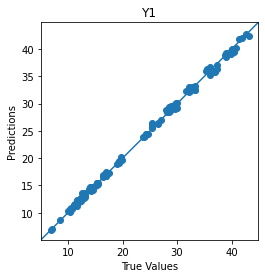

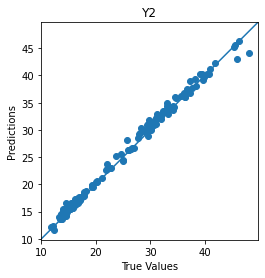

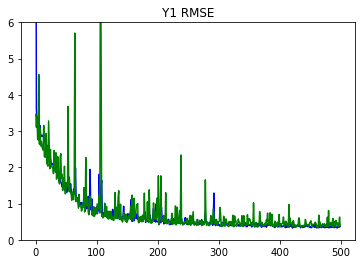

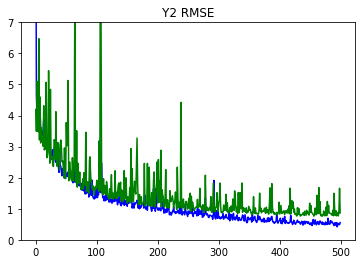

In [9]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)